## Skenario
> Business Analyst(BA) berasumsi bahwa nasabah yang pergi (*churn*) adalah nasabah yang tidak aktif dan tidak memiliki kartu kredit, tetapi asumsi itu harus dibuktikan terlebih dahulu menggunakan data agar kredibel guna keputusan apa yang akan diambil untuk mengurangi/menarik kembali nasabah yang pergi

## 1. Merancang Uji Coba

### a. Menentukan Hipotesis

Karena kita masih tidak mengetahui apakah asumsi bahwa nasabah yang *churn* adalah yang tidak memiliki kartu kredit itu benar atau salah, maka kita akan menggunakan **two-tailed-test**:

$$H_0: p = p_0$$
$$H_a: p \ne p_0$$

dimana $p$ dan $p_0$ nilai untuk conversion rate antara yang aktif dan tidak aktif. kita juga menetapkan **confidence level 95%**:

$$\alpha = 0.05$$

Nilai $\alpha$ ditetapkan sebagai ambang batas, dimana "jika nilai hasil uji coba lebih ($p$-value) atau kurang dari $\alpha$, maka kita akan menolak null hipotesis". Karena $\alpha=0.05$ (Menunjukan 5% probability), dengan kata lain confidence rate kita (1 - $\alpha$) adalah 95%.

### b. Memilih Variabel

Untuk melakukan test, kita memerlukan 2 nilai pada kolom **credit_card**:
* `1` adalah orang yang memiliki kartu kreadit (+)
* `0` adalah orang yang tidak memiliki kartu kredit (-)
kolom **credit_card** ini akan menjadi kolom *independen* karena sebagai kolom uji coba.
Untuk kolom *dependen* akan menggunakan kolom **churn** karena kolom ini berperan sebagai target, dimana:
* `1` adalah nasabah yang *churn* (+)
* `0` adalah nasabah yang tidak *churn* (-)

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

## 2. Mengambil dan Mempersiapkan Data

1. Download the <a href='https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset'>dataset from Kaggle</a>
2. Read dataset ke dalam bentuk pandas DataFrame
3. Memeriksa dan Membersihkan data sesuai kebutuhan

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ronimerdiansah","key":"348f3c0ae2b3fdaae4760582c857b6e3"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d gauravtopre/bank-customer-churn-dataset

  0% 0.00/187k [00:00<?, ?B/s]
100% 187k/187k [00:00<00:00, 69.7MB/s]


In [ ]:
!mkdir bank-customer-churn-dataset
!unzip bank-customer-churn-dataset.zip -d bank-customer-churn-dataset
!ls bank-customer-churn-dataset

Archive:  bank-customer-churn-dataset.zip
  inflating: bank-customer-churn-dataset/Bank Customer Churn Prediction.csv  
'Bank Customer Churn Prediction.csv'


In [ ]:
df = pd.read_csv('/content/bank-customer-churn-dataset/Bank Customer Churn Prediction.csv')
df

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,15569892,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,15584532,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,15682355,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [ ]:
for col in df:
    print(f"\033[1m{col} \n{20 * '-'}\033[0m")
    print(df[col].value_counts(), '\n')

customer_id 
--------------------
15634602    1
15667932    1
15766185    1
15667632    1
15599024    1
           ..
15599078    1
15702300    1
15660735    1
15671390    1
15628319    1
Name: customer_id, Length: 10000, dtype: int64 

credit_score 
--------------------
850    233
678     63
655     54
705     53
667     53
      ... 
404      1
351      1
365      1
417      1
419      1
Name: credit_score, Length: 460, dtype: int64 

country 
--------------------
France     5014
Germany    2509
Spain      2477
Name: country, dtype: int64 

gender 
--------------------
Male      5457
Female    4543
Name: gender, dtype: int64 

age 
--------------------
37    478
38    477
35    474
36    456
34    447
     ... 
92      2
82      1
88      1
85      1
83      1
Name: age, Length: 70, dtype: int64 

tenure 
--------------------
2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: tenure, dtype: int64 

balance 
-

In [ ]:
df.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [ ]:
pd.crosstab(df['credit_card'], df['churn'])

churn,0,1
credit_card,,
0,2332,613
1,5631,1424


In [ ]:
session_counts = df['customer_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'Terdapat {multi_users} nasabah yang muncul lebih dari sekali didalam dataset')

Terdapat 0 nasabah yang muncul lebih dari sekali didalam dataset


Karena tidak terdapat data yang bernilai null maupun duplikasi id nasabah, maka bisa kita lanjutkan ke tahap berikutnya

## 3. Mem-visualisasi nilai yang di dapatkan

Hal pertama yang dapat kita lakukan adalah menghitung beberapa statistik dasar untuk mendapatkan gambaran seperti apa sampel kita.

In [ ]:
conversion_rates = df.groupby('credit_card')['churn']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
credit_card,,,
0,0.208,0.406,0.007
1,0.202,0.401,0.005


dari hasil diatas dapat kita lihat bahwa conversion rate antara nasabah yang memilki kartu kredit dengan nasabah yang tidak memilki kartu kredit tidak memiliki perbedaan yang signifikan hanya **20.2%** dan **20.8%**

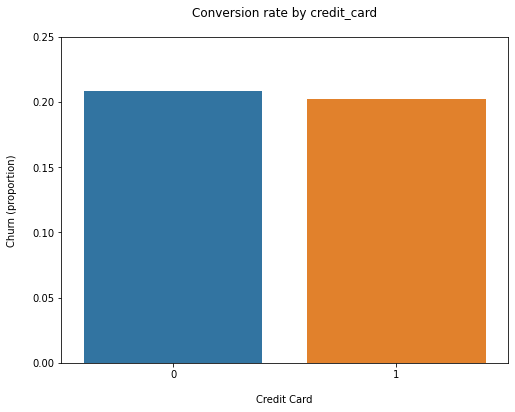

In [ ]:
plt.figure(figsize=(8,6))

sns.barplot(x=df['credit_card'], y=df['churn'], ci=False)

plt.ylim(0, 0.25)
plt.title('Conversion rate by credit_card', pad=20)
plt.xlabel('Credit Card', labelpad=15)
plt.ylabel('Churn (proportion)', labelpad=15);

dari plot tersebut dapat kita lihat lebih jelas bahwa nasabah yang tidak memiliki kartu kredit memiliki nilai yang lebih tinggi dibandingkan nasabah yang memiliki kartu kredit

## 4. Menguji Hipotesis

Langkah terakhir dalam analisis adalah menguji hipotesis, karena data memilki banyak sample maka kita bisa menggunakan distribusi normal untuk menghitung $p$-value atau juga biasa disebut **z-test**

In [ ]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [ ]:
positive_results = df[df['credit_card'] == 0]['churn']
negative_results = df[df['credit_card'] == 1]['churn']

In [ ]:
n_pos = positive_results.count()
n_neg = negative_results.count()
successes = [positive_results.sum(), negative_results.sum()]
nobs = [n_pos, n_neg]

z_stat, pval = proportions_ztest(successes, nobs=nobs)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')

z statistic: 0.71
p-value: 0.475


## 5. Menarik Kesimpulan

Karena nilai $p$-value: 0.475 memiliki perbedaan nilai yang jauh dengan $\alpha$=0.05 kita tidak bisa menolak null hipotesis yang berarti bahwa '*Nasabah yang pergi (churn) adalah nasabah yang tidak aktif dan juga tidak memiliki kartu kredit*'

ini akan jadi masukan yang sangat bermanfaat untuk BA bagaimana mengatasi masalah *Chun* ini.

Link dataset:
https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset

References:
https://towardsdatascience.com/ab-testing-with-python-e5964dd66143